In [1]:
import gym
import numpy as np
import time
import os
import cv2
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.optim as optim 
import torch.nn.functional as F 
from torchsummary import summary
# import wandb

In [12]:
class Agent:
    def __init__(self, 
                 env: 'Environment',
                 input_frame: ('int: the number of channels of input image'),
                 input_dim: ('int: the width and height of pre-processed input image'),
                 num_frames: ('int: Total number of frames'),
                 eps_decay: ('float: Epsilon Decay_rate'),
                 gamma: ('float: Discount Factor'),
                 target_update_freq: ('int: Target Update Frequency (by frames)'),
                 update_type: ('str: Update type for target network. Hard or Soft')='hard',
                 soft_update_tau: ('float: Soft update ratio')=None,
                 batch_size: ('int: Update batch size')=32,
                 buffer_size: ('int: Replay buffer size')=1000000,
                 update_start_buffer_size: ('int: Update starting buffer size')=50000,
                 learning_rate: ('float: Learning rate')=0.0004,
                 eps_min: ('float: Epsilon Min')=0.1,
                 eps_max: ('float: Epsilon Max')=1.0,
                 device_num: ('int: GPU device number')=0,
                 rand_seed: ('int: Random seed')=None,
                 plot_option: ('str: Plotting option')=False,
                 model_path: ('str: Model saving path')='./'):
        
        action_dim = env.action_space.n
        self.device = torch.device(f'cuda:{device_num}' if torch.cuda.is_available() else 'cpu')
        self.model_path = model_path
        
        self.env = env
        self.input_frames = input_frame
        self.input_dim = input_dim
        self.num_frames = num_frames
        self.epsilon = eps_max
        self.eps_decay = eps_decay
        self.eps_min = eps_min
        self.gamma = gamma
        self.target_update_freq = target_update_freq
        self.update_cnt = 0
        self.update_type = update_type
        self.tau = soft_update_tau
        self.batch_size = batch_size
        self.buffer_size = buffer_size
        self.update_start = update_start_buffer_size
        self.seed = rand_seed
        self.plot_option = plot_option
        
        self.q_current = QNetwork((self.input_frames, self.input_dim, self.input_dim), action_dim).to(self.device)
        self.q_target = QNetwork((self.input_frames, self.input_dim, self.input_dim), action_dim).to(self.device)
        self.q_target.load_state_dict(self.q_current.state_dict())
        self.q_target.eval()
        self.optimizer = optim.Adam(self.q_current.parameters(), lr=learning_rate) 

        self.memory = ReplayBuffer(self.buffer_size, (self.input_frames, self.input_dim, self.input_dim), self.batch_size)

    def select_action(self, state: 'Must be pre-processed in the same way while updating current Q network. See def _compute_loss'):
        
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        else:
            # if normalization is applied to the image such as devision by 255, MUST be expressed 'state/255' below.
            state = torch.FloatTensor(state).to(self.device).unsqueeze(0)/255
            action = self.q_current(state).argmax()
            return action.detach().item()

    def processing_resize_and_gray(self, frame):
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY) # Pure
        # frame = cv2.cvtColor(frame[:177, 32:128, :], cv2.COLOR_RGB2GRAY) # Boxing
        # frame = cv2.cvtColor(frame[2:198, 7:-7, :], cv2.COLOR_RGB2GRAY) # Breakout
        frame = cv2.resize(frame, dsize=(self.input_dim, self.input_dim)).reshape(self.input_dim, self.input_dim).astype(np.uint8)
        return frame 

    def get_state(self, action, skipped_frame=0):
        '''
        num_frames: how many frames to be merged
        input_size: hight and width of input resized image
        skipped_frame: how many frames to be skipped
        '''
        next_state = np.zeros((self.input_frames, self.input_dim, self.input_dim))
        rewards = 0
        dones = 0
        for i in range(self.input_frames): 
            for j in range(skipped_frame):
                state, reward, done, _ = self.env.step(action) 
                rewards += reward 
                dones += int(done) 
            state, reward, done, _ = self.env.step(action) 
            next_state[i] = self.processing_resize_and_gray(state) 
            rewards += reward 
            dones += int(done) 
        return rewards, next_state, dones

    def get_init_state(self):
        state = self.env.reset()
        action = self.env.action_space.sample()
        _, state, _ = self.get_state(action, 
                               skipped_frame=0)
        return state
    
    def store(self, state, action, reward, next_state, done):
        self.memory.store(state, action, reward, next_state, done)

    def update_current_q_net(self):
        batch = self.memory.batch_load()
        loss = self._compute_loss(batch)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def target_soft_update(self):
        for target_param, current_param in zip(self.q_target.parameters(), self.q_current.parameters()):
            target_param.data.copy_(self.tau*current_param.data + (1.0-self.tau)*target_param.data)

    def target_hard_update(self):
        self.update_cnt = (self.update_cnt+1) % self.target_update_freq
        if self.update_cnt==0:
            self.q_target.load_state_dict(self.q_current.state_dict())

    def train(self):
        tic = time.time()
        losses = []
        scores = []
        epsilons = []
        avg_scores = [[-1000]]

        score = 0

        print("Storing initial buffer..")
        state = self.get_init_state()
        for frame_idx in range(1, self.update_start+1):
            action = self.select_action(state)
            reward, next_state, done = self.get_state(action, skipped_frame=0)
            self.store(state, action, reward, next_state, done)
            state = next_state
            if done: state = self.get_init_state()

        print("Done. Start learning..")
        for frame_idx in range(1, self.num_frames+1):
            action = self.select_action(state)
            reward, next_state, done = self.get_state(action, skipped_frame=0)
            self.store(state, action, reward, next_state, done)
            loss = self.update_current_q_net()

            if self.update_type=='hard':   self.target_hard_update()
            elif self.update_type=='soft': self.target_soft_update()
            
            score += reward
            losses.append(loss)

            if done:
                scores.append(score)
                if np.mean(scores[-10:]) > max(avg_scores):
                    torch.save(self.q_current.state_dict(), self.model_path+'{}.pt'.format(frame_idx))
                    print("          | Model saved. Mean score over 10 episode: {}".format(scores[-10:]), '/'.join(os.getcwd().split('/')[-3:]), end='\r')
                avg_scores.append(np.mean(scores[-10:]))

                if self.plot_option=='inline': 
                    scores.append(score)
                    self._plot(frame_idx, scores, losses, epsilons)
                elif self.plot_option=='wandb': 
                    wandb.log({'Score': score, 'loss(10 frames avg)': np.mean(losses[-10:]), 'Epsilon': self.epsilon})
                    print(score, end='\r')
                else: 
                    print(score, end='\r')
                    
                score=0
                state = self.get_init_state()
            else: state = next_state

            epsilons.append(self.epsilon)
            self.epsilon = max(self.epsilon-self.eps_decay, self.eps_min)

        print("Total training time: {}(hrs)".format((time.time()-tic)/3600))
                
    def _compute_loss(self, batch: "Dictionary (S, A, R', S', Dones)"):
        # If normalization is used, it must be applied to 'state' and 'next_state' here. ex) state/255
        states = torch.FloatTensor(batch['states']).to(self.device) / 255
        next_states = torch.FloatTensor(batch['next_states']).to(self.device) / 255
        actions = torch.LongTensor(batch['actions'].reshape(-1, 1)).to(self.device)
        rewards = torch.FloatTensor(batch['rewards'].reshape(-1, 1)).to(self.device)
        dones = torch.FloatTensor(batch['dones'].reshape(-1, 1)).to(self.device)

        current_q = self.q_current(states).gather(1, actions)
        # The next line is the only difference from Vanila DQN.
        next_q = self.q_target(next_states).gather(1, self.q_current(next_states).argmax(axis=1, keepdim=True)).detach()
        mask = 1 - dones
        target = (rewards + (mask * self.gamma * next_q)).to(self.device)

        loss = F.smooth_l1_loss(current_q, target)
        return loss

    def _plot(self, frame_idx, scores, losses, epsilons):
        clear_output(True) 
        plt.figure(figsize=(20, 5), facecolor='w') 
        plt.subplot(131)  
        plt.title('frame %s. score: %s' % (frame_idx, np.mean(scores[-10:])))
        plt.plot(scores) 
        plt.subplot(132) 
        plt.title('loss') 
        plt.plot(losses) 
        plt.subplot(133) 
        plt.title('epsilons')
        plt.plot(epsilons) 
        plt.show() 

# if __name__=='__main__':
#     agent = Agent()

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim 
import torch.nn.functional as F 

# The network structure is the only difference.
class QNetwork(nn.Module):
    
    def __init__(self, input_dim, action_dim, rand_seed=False,
                conv_channel_1=32, conv_channel_2=64, conv_channel_3=64,
                kernel_1=8, kernel_2=4, kernel_3=3, 
                stride_1=4, stride_2=2, stride_3=1):

        super(QNetwork, self).__init__()
        # self.seed = torch.manual_seed(rand_seed)
        self.Conv1 = nn.Conv2d(input_dim[0], conv_channel_1, (kernel_1,kernel_1), stride=stride_1)
        self.Conv2 = nn.Conv2d(conv_channel_1, conv_channel_2, (kernel_2,kernel_2), stride=stride_2)
        self.Conv3 = nn.Conv2d(conv_channel_2, conv_channel_3, (kernel_3,kernel_3), stride=stride_3)

        def calculate_conv2d_size(size, kernel_size, stride):
            return (size - (kernel_size - 1) - 1) // stride  + 1

        w, h = input_dim[1], input_dim[2]
        convw = calculate_conv2d_size(calculate_conv2d_size(calculate_conv2d_size(w,kernel_1,stride_1),
                                                            kernel_2,stride_2),
                                      kernel_3,stride_3)
        convh = calculate_conv2d_size(calculate_conv2d_size(calculate_conv2d_size(h,kernel_1,stride_1),
                                                            kernel_2,stride_2),
                                      kernel_3,stride_3)
        linear_input_size = convw * convh * conv_channel_3

        self.V_fc1 = nn.Linear(linear_input_size, 512)
        self.V_fc2 = nn.Linear(512, 1)
        self.A_fc1 = nn.Linear(linear_input_size, 512)
        self.A_fc2 = nn.Linear(512, action_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.Conv1(x))
        x = self.relu(self.Conv2(x))
        x = self.relu(self.Conv3(x))
        x = x.reshape(x.shape[0], -1)
        V = self.V_fc2(self.relu(self.V_fc1(x)))
        A = self.A_fc2(self.relu(self.A_fc1(x)))
        Q = V + A - A.mean(dim=-1, keepdim=True)
        return Q

# Test
state_size = (4, 84, 84)
action_size = 10
net = QNetwork(state_size, action_size, 
               conv_channel_1=32, conv_channel_2=64, conv_channel_3=64)
test = torch.randn(size=(64, 4, 84, 84))
print(net(test).shape) 

torch.Size([64, 10])


In [4]:
class ReplayBuffer:

    def __init__(self, 
                 buffer_size: int, 
                 input_dim: tuple, 
                 batch_size: int):

        if len(input_dim)!=3:
            print("state dim should be 3-dim! (WxHxCH). Please check if input_dim is right")
            raise

        self.batch_size = batch_size
        self.buffer_size = buffer_size
        self.save_count, self.current_size = 0, 0

        self.state_buffer = np.ones((buffer_size, input_dim[0], input_dim[1], input_dim[2]), 
                                    dtype=np.uint8) # WARN: data type is np.int8 so that it should be stored ONLY 0~255 integer!!!
        self.action_buffer = np.ones(buffer_size, dtype=np.uint8) 
        self.reward_buffer = np.ones(buffer_size, dtype=np.float32) 
        self.next_state_buffer = np.ones((buffer_size, input_dim[0], input_dim[1], input_dim[2]),  
                                         dtype=np.uint8) # WARN: data type is np.int8 so that it should be stored ONLY 0~255 integer!!!
        self.done_buffer = np.ones(buffer_size, dtype=np.uint8) 

    def __len__(self):
        return self.current_size

    def store(self, 
              state: np.ndarray, 
              action: int, 
              reward: float, 
              next_state: np.ndarray, 
              done: int):

        self.state_buffer[self.save_count] = state
        self.action_buffer[self.save_count] = action
        self.reward_buffer[self.save_count] = reward
        self.next_state_buffer[self.save_count] = next_state
        self.done_buffer[self.save_count] = done
        
        self.save_count = (self.save_count + 1) % self.buffer_size
        self.current_size = min(self.current_size+1, self.buffer_size)

    def batch_load(self):
        indices = np.random.randint(self.current_size, size=self.batch_size)
        return dict(
                states=self.state_buffer[indices], 
                actions=self.action_buffer[indices],
                rewards=self.reward_buffer[indices],
                next_states=self.next_state_buffer[indices], 
                dones=self.done_buffer[indices]) 
    
if __name__=='__main__':
    buffer_size = 100
    state_dim = (4, 84, 84)
    batch_size = 64
    buffer = ReplayBuffer(buffer_size, state_dim, batch_size)
    samples_s = np.ones((1000, 4, 84, 84))
    samples_a = np.ones((1000, 1))
    samples_r = np.ones((1000, 1))
    samples_n_s = np.ones((1000, 4, 84, 84))
    samples_d = np.ones((1000, 1))
    for s, a, r, n_s, d in zip(samples_s, samples_a, samples_r, samples_n_s, samples_d):
        buffer.store(s, a, r, n_s, d)

    print(buffer.batch_load()['states'].shape)
    print(buffer.batch_load()['rewards'].shape)
    print(buffer.batch_load()['dones'].shape)
    print(buffer.batch_load()['next_states'].shape)
    print(buffer.batch_load()['actions'].shape)
    print(buffer.current_size)
    print(buffer.batch_size)
        

(64, 4, 84, 84)
(64,)
(64,)
(64, 4, 84, 84)
(64,)
100
64


In [10]:
# env = gym.make('CartPole-v0')
# env = gym.make('LunarLander-v2')
# env = gym.make('Breakout-v0')
# env = gym.make('BreakoutDeterministic-v4')
# env = gym.make('BoxingDeterministic-v4')
# env = gym.make('PongDeterministic-v4')
# env_name = 'Boxing-'+version
# env.seed(0)
env_name = 'PongDeterministic'
env_version = 4
env_name = env_name+'-v'+str(env_version)
env = gym.make(env_name)
input_dim = 84
input_frame = 4

print("env_name", env_name) 
print(env.unwrapped.get_action_meanings(), env.action_space.n) 

update_start_buffer_size = 50000
num_frames = 10000000
eps_max = 1.0
eps_min   = 0.1
eps_decay = 1/1200000
gamma = 0.99

buffer_size = int(7e5) 
buffer_size = 128
batch_size = 64           
update_type = 'hard'
soft_update_tau = 0.002
learning_rate = 0.00088
target_update_freq = 150

device_num = 0
rand_seed = None

model_number = 0
model_save_path = \
f'./model_save/{env_name}_num_f:{num_frames}_eps_dec:{round(eps_decay,8)}f\
_gamma:{gamma}_tar_up_frq:{target_update_freq}f\
_up_type:{update_type}_soft_tau:{soft_update_tau}f\
_batch:{batch_size}_buffer:{buffer_size}f\
_up_start:{update_start_buffer_size}_lr:{learning_rate}f\
_eps_min:{eps_min}_device:{device_num}_rand:{rand_seed}_{model_number}/'
if not os.path.exists('./model_save/'):
    os.mkdir('./model_save/')
if not os.path.exists(model_save_path):
    os.mkdir(model_save_path)
print("model_save_path:", model_save_path)

# plot_option = 'wandb'
# plot_option = 'inline'
plot_option = False

if plot_option=='wandb':
    os.environ['WANDB_NOTEBOOK_NAME'] = 'RL_experiment'
    wandb_project_name = 'temporary'
    rand_name = ('').join(map(str, np.random.randint(10, size=(5,))))
    wandb.init(
            project=wandb_project_name,
            name=f"{env_name}_{rand_name}",
            config={"env_name": env_name, 
                    "input_frame": input_frame,
                    "input_dim": input_dim,
                    "eps_max": eps_max,
                    "eps_min": eps_min,
                    "eps_decay": eps_decay,
                    "num_frames": num_frames,
                    "gamma": gamma,
                    "buffer_size": buffer_size,
                    "update_start_buffer_size": update_start_buffer_size,
                    "batch_size": batch_size,
                    "update_type": update_type,
                    "soft_update_tau": soft_update_tau,
                    "learning_rate": learning_rate,
                    "target_update_freq (unit:frames)": target_update_freq,
                    }
            )

agent = Agent( 
    env,
    input_frame,
    input_dim,
    num_frames,
    eps_decay,
    gamma,
    target_update_freq,
    update_type,
    soft_update_tau,
    batch_size,
    buffer_size,
    update_start_buffer_size,
    learning_rate,
    eps_min,
    eps_max,
    device_num,
    rand_seed,
    plot_option,
    model_save_path,
) 

env_name PongDeterministic-v4
['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE'] 6
model_save_path: ./model_save/PongDeterministic-v4_num_f:10000000_eps_dec:8.3e-07f_gamma:0.99_tar_up_frq:150f_up_type:hard_soft_tau:0.002f_batch:64_buffer:128f_up_start:50000_lr:0.00088f_eps_min:0.1_device:0_rand:None_0/


In [ ]:
agent.train()

In [6]:
env_name = 'PongDeterministic-v4'
print("env_name", env_name) 
print(env.unwrapped.get_action_meanings(), env.action_space.n) 

env = gym.make(env_name)
num_action = env.action_space.n
action_list = env.unwrapped.get_action_meanings()

env_name PongDeterministic-v4
['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE'] 6


0


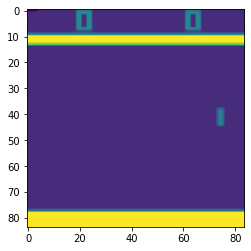

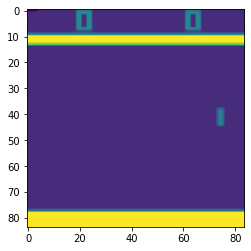

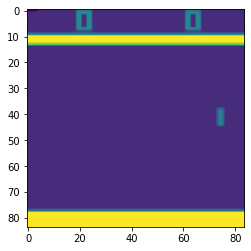

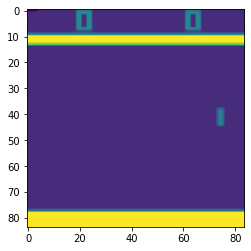

In [8]:
state = agent.get_init_state()
for frame in state:
    fig = plt.figure(facecolor='w')
    plt.imshow(frame)  
#     plt.title(f'A:{action_list[action]}, R:{r}')

In [ ]:
print("Done. Start learning..")
for frame_idx in range(1, agent.num_frames+1):
    action = agent.select_action(state)
    reward, next_state, done = agent.get_state(action, skipped_frame=0)
    agent.store(state, action, reward, next_state, done)
    loss = agent.update_current_q_net()

    if agent.update_type=='hard':   agent.target_hard_update()
    elif agent.update_type=='soft': agent.target_soft_update()

    score += reward
    losses.append(loss)

    if done:
        scores.append(score)
        if np.mean(scores[-10:]) > max(avg_scores):
            torch.save(agent.q_current.state_dict(), agent.model_path+'{}.pt'.format(frame_idx))
            print("          | Model saved. Mean score over 10 episode: {}".format(scores[-10:]), '/'.join(os.getcwd().split('/')[-3:]), end='\r')
        avg_scores.append(np.mean(scores[-10:]))

        if agent.plot_option=='inline': 
            scores.append(score)
            agent._plot(frame_idx, scores, losses, epsilons)
        elif agent.plot_option=='wandb': 
            wandb.log({'Score': score, 'loss(10 frames avg)': np.mean(losses[-10:]), 'Epsilon': agent.epsilon})
            print(score, end='\r')
        else: 
            print(score, end='\r')

        score=0
        state = agent.get_init_state()
    else: state = next_state

    epsilons.append(agent.epsilon)
    agent.epsilon = max(agent.epsilon-agent.eps_decay, agent.eps_min)

print("Total training time: {}(hrs)".format((time.time()-tic)/3600))